# OTE-01: Initial Image Mosaic

In [2]:
# Standard Library Imports
import os
import re
import time
import multiprocessing

# Third Party Imports
import pprint
from glob import glob
import numpy as np
import webbpsf
from astropy.io import fits
from astropy.io import ascii as asc
import matplotlib.pyplot as plt

# Local Imports (from nircam_simulator package)
from mirage import imaging_simulator
from mirage.seed_image import catalog_seed_image
from mirage.dark import dark_prep
from mirage.ramp_generator import obs_generator
from mirage.apt import apt_inputs
from mirage.yaml import yaml_generator, write_observationlist
from mirage.catalogs import get_catalog
from mirage.psf import psf_library

# View matplotlib plots inline
%matplotlib inline

### Define location of input and output files

In [3]:
# Where the pointing and XML file for this particular OTE CAR are located
ote_dir = '/user/lchambers/OTECommSims/OTE01_reducedmosaic/'

# Where the output FITS files will be saved to
library_root_dir = '/user/lchambers/OTECommSims/test_library_output/'

In [6]:
prop_id = 1134

# Change if you named your files differently.
root = 'OTE01-{}-reduced_mosaic'.format(prop_id)

pointing_file = os.path.join(ote_dir, '{}.pointing'.format(root))
xml_file = os.path.join(ote_dir, '{}.xml'.format(root))

---
# First, generate PSF library files

### Get the source catalogs

In [7]:
# Get SW and LW catalogs
cats = get_catalog.get_all_catalogs(pointing_file, prop_id)
target_coords, catalog_filenames_sw, catalog_filenames_lw = cats

Target coordinates:  146.87731 63.24781
Shortwave catalog file 2MASS_RA146.88deg_Dec63.25deg.list already exists. Will not overwrite.
Longwave catalog file WISE_RA146.88deg_Dec63.25deg.list already exists. Will not overwrite.


### Get the observation/visit information from the APT files

In [8]:
# Get the information from the pointing file
apt_prop = apt_inputs.AptInput()
pointing_tab = apt_prop.get_pointing_info(pointing_file, '1140')
n_exposures = len(pointing_tab['visit_id'])

In [9]:
# Create dictionary that mirrors the program structure
program_structure = {}
for i in range(n_exposures):
    obs_num = pointing_tab['obs_num'][i]
    visit_num = pointing_tab['visit_num'][i]
    activity_id = pointing_tab['act_id'][i]
    
    obs_key = 'Observation{}'.format(obs_num)
    visit_key = 'Visit{}'.format(visit_num)
    
    program_structure.setdefault(obs_key, {})
    visit_dict = program_structure[obs_key].setdefault(visit_key, []).append('Activity{}'.format(activity_id))                                                                      
    
pprint.pprint(program_structure)  

{'Observation001': {'Visit001': ['Activity01',
                                 'Activity02',
                                 'Activity03',
                                 'Activity04'],
                    'Visit002': ['Activity05', 'Activity06']},
 'Observation002': {'Visit001': ['Activity07',
                                 'Activity08',
                                 'Activity09',
                                 'Activity0a'],
                    'Visit002': ['Activity0b',
                                 'Activity0c',
                                 'Activity0d',
                                 'Activity0e'],
                    'Visit003': ['Activity0f', 'Activity0g'],
                    'Visit004': ['Activity0h', 'Activity0i'],
                    'Visit005': ['Activity0j', 'Activity0k'],
                    'Visit006': ['Activity0l',
                                 'Activity0m',
                                 'Activity0n',
                                 'Activity0

                                 'Activity5c',
                                 'Activity5d',
                                 'Activity5e'],
                    'Visit006': ['Activity5f',
                                 'Activity5g',
                                 'Activity5h',
                                 'Activity5i'],
                    'Visit007': ['Activity5j',
                                 'Activity5k',
                                 'Activity5l',
                                 'Activity5m'],
                    'Visit008': ['Activity5n',
                                 'Activity5o',
                                 'Activity5p',
                                 'Activity5q'],
                    'Visit009': ['Activity5r', 'Activity5s'],
                    'Visit010': ['Activity5t', 'Activity5u'],
                    'Visit011': ['Activity5v', 'Activity5w'],
                    'Visit012': ['Activity5x', 'Activity5y'],
                    'Visit013': ['Activity5

In [10]:
# Create directory structure based on dictionary

psf_paths = []
program_dir = os.path.join(library_root_dir, root)
for observation in program_structure.keys():
    for visit in program_structure[observation].keys():
        for activity in program_structure[observation][visit]:
            activity_dir = os.path.join(program_dir, observation, visit, activity)
            if not os.path.exists(activity_dir):
                os.makedirs(activity_dir)
            psf_paths.append(activity_dir)

## Generate the PSF array

In [16]:
nc = webbpsf.NIRCam()
nc, ote = webbpsf.enable_adjustable_ote(nc)

# Add random pistons
random_pistons = np.random.randn(18)*50000 # massive ~cm errors (50000 micron = 5e-2 m)
for i, seg in enumerate(ote.segnames[0:18]):  # don't piston "segment 19" the SM
    ote.move_seg_local(seg, piston=random_pistons[i])
    
# Just show one segment
pupil = webbpsf.webbpsf_core.one_segment_pupil('A3')
ote.amplitude = pupil[0].data

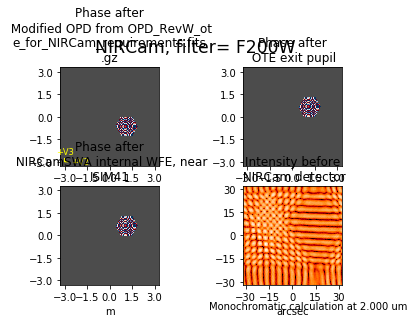

In [17]:
ote01_psf = nc.calc_psf(monochromatic=2e-6, oversample=1, fov_pixels=2048, display=True)

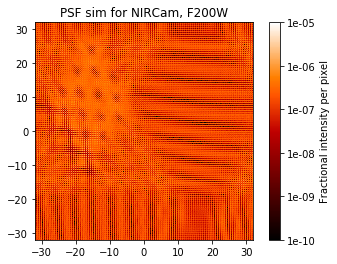

In [20]:
webbpsf.display_psf(ote01_psf, vmin=1e-10, vmax=1e-5)

In [10]:
# Create observation table file from APT files
observationlist_file = os.path.join(os.getcwd(), ote_dir, root + '_observationlist.yaml')
write_observationlist.write_yaml(xml_file, pointing_file, observationlist_file, 
                                 ps_cat_sw=catalog_filenames_sw, ps_cat_lw=catalog_filenames_lw)

Found 6 exposure(s) for observation 1 (Central)
* * * OFFSET OF (990, 0) IN OBS 2 NOT APPLIED ***
Found 39 exposure(s) for observation 2 (W)
* * * OFFSET OF (-990, 0) IN OBS 3 NOT APPLIED ***
Found 39 exposure(s) for observation 3 (E)
* * * OFFSET OF (565, 960) IN OBS 4 NOT APPLIED ***
Found 45 exposure(s) for observation 4 (NW)
* * * OFFSET OF (-565, 960) IN OBS 5 NOT APPLIED ***
Found 45 exposure(s) for observation 5 (NE)
* * * OFFSET OF (565, -960) IN OBS 6 NOT APPLIED ***
Found 45 exposure(s) for observation 6 (SW)
* * * OFFSET OF (-565, -960) IN OBS 7 NOT APPLIED ***
Found 45 exposure(s) for observation 7 (SE)

Successfully wrote 7 observations to /Users/lchambers/TEL/mirage/OTECommissioning/OTE01_reducedmosaic/OTE01-1134-reduced_mosaic_observationlist.yaml


In [23]:
# Create a series of data simulator input yaml files from APT files
yam = yaml_generator.SimInput()

yam.input_xml = xml_file
yam.pointing_file = pointing_file
siaf_file = os.path.expandvars('$MIRAGE_DATA/nircam/reference_files/SIAF/NIRCam_SIAF_2018-01-08.csv')
yam.siaf = siaf_file
yam.output_dir = ote_dir #os.path.join(os.getcwd(), ote_dir)
yam.simdata_output_dir = ote_dir #os.path.join(os.getcwd(), ote_dir)
yam.observation_table = observationlist_file

yam.use_JWST_pipeline = False # changed to False
yam.use_linearized_darks = True # changed to True
yam.datatype = 'linear'

yam.reffile_setup()
yam.create_inputs()

Using /Users/lchambers/TEL/mirage/OTECommissioning/OTE01_reducedmosaic/OTE01-1134-reduced_mosaic_observationlist.yaml, 
      /Users/lchambers/TEL/mirage/OTECommissioning/OTE01_reducedmosaic/OTE01-1134-reduced_mosaic.xml, 
      /Users/lchambers/TEL/mirage/OTECommissioning/OTE01_reducedmosaic/OTE01-1134-reduced_mosaic.pointing, and 
      /ifs/jwst/wit/mirage_data/nircam/reference_files/SIAF/NIRCam_SIAF_2018-01-08.csv 
      to generate observation table.

Found 6 exposure(s) for observation 1 (Central)
* * * OFFSET OF (990, 0) IN OBS 2 NOT APPLIED ***
Found 39 exposure(s) for observation 2 (W)
* * * OFFSET OF (-990, 0) IN OBS 3 NOT APPLIED ***
Found 39 exposure(s) for observation 3 (E)
* * * OFFSET OF (565, 960) IN OBS 4 NOT APPLIED ***
Found 45 exposure(s) for observation 4 (NW)
* * * OFFSET OF (-565, 960) IN OBS 5 NOT APPLIED ***
Found 45 exposure(s) for observation 5 (NE)
* * * OFFSET OF (565, -960) IN OBS 6 NOT APPLIED ***
Found 45 exposure(s) for observation 6 (SW)
* * * OFFSET O

In [24]:
# Print information about the yaml files that were generated.
yfiles = glob(os.path.join(ote_dir, 'jw*yaml'))

obs_numbers = [f.split('/')[-1].split('_')[0] for f in yfiles]
all_obs_numbers = list(set(obs_numbers))
all_obs_numbers.sort()

n_obs = len(set([int(number[9:11]) for number in all_obs_numbers]))

print('Found {} yaml files.'.format(len(obs_numbers)))
print('({} exposures across {} observations)'.format(len(all_obs_numbers), n_obs))
# pprint.pprint(all_obs_numbers)

Found 2640 yaml files.
(90 exposures across 7 observations)


In [31]:
# Get list of YAML files for observation 1 (all 10 detectors)
obs1_visit1_files = glob(os.path.join(ote_dir, 'jw01134001*yaml'))
print('{} yaml files found in program APT 1134 Observation 1'.format(len(obs1_visit1_files)))

60 yaml files found in program APT 1134 Observation 1


In [40]:
with fits.open(obs1_fits_files[0]) as hdu:
    hdu.info()

Filename: /user/lchambers/OTECommSims/OTE01_reducedmosaic/jw01134001002_01105_00001_nrcb4_linear.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      72   ()      
  1  SCI           1 ImageHDU        36   (2048, 2048, 4, 1)   float32   
  2  PIXELDQ       1 ImageHDU        10   (2048, 2048)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        10   (2048, 2048, 4, 1)   uint8   
  4  ERR           1 ImageHDU        10   (2048, 2048, 4, 1)   float32   
  5  ZEROFRAME     1 ImageHDU         9   (2048, 2048, 1)   float32   
  6  GROUP         1 BinTableHDU     35   4R x 13C   [I, I, I, J, I, 26A, I, I, I, I, 36A, D, D]   


In [39]:
# Generate "mosaic" from images
obs1_fits_files = glob('/user/lchambers/OTECommSims/OTE01_reducedmosaic/jw*linear.fits')

for f in sorted(obs1_fits_files):
    print(f.split('/')[-1])
    with fits.open(f) as hdu:
        print(hdu[0].header['TARG_RA'])
        print(hdu[0].header['RA_V1'])
        print(hdu[0].header['XOFFSET'], hdu[0].header['YOFFSET'])
        print()

jw01134001001_01101_00001_nrca1_linear.fits
146.918809923748
146.918809923748
-53.666 -107.128

jw01134001001_01101_00001_nrca2_linear.fits
146.9182797430757
146.9182797430757
-53.666 -107.128

jw01134001001_01101_00001_nrca3_linear.fits
146.8764227293127
146.8764227293127
-53.666 -107.128

jw01134001001_01101_00001_nrca4_linear.fits
146.8766345024596
146.8766345024596
-53.666 -107.128

jw01134001001_01101_00001_nrca5_linear.fits
146.8975309891544
146.8975309891544
-53.666 -107.128

jw01134001001_01101_00001_nrcb1_linear.fits
146.7696294871521
146.7696294871521
-53.666 -107.128

jw01134001001_01101_00001_nrcb2_linear.fits
146.7695640616638
146.7695640616638
-53.666 -107.128

jw01134001001_01101_00001_nrcb3_linear.fits
146.8115443605752
146.8115443605752
-53.666 -107.128

jw01134001001_01101_00001_nrcb4_linear.fits
146.811747707929
146.811747707929
-53.666 -107.128

jw01134001001_01101_00001_nrcb5_linear.fits
146.7890342881445
146.7890342881445
-53.666 -107.128

jw01134001001_01102_0000